From cnntrain and cnntest, the first two digits in each file name represent the resolution $y_{i}$ of the patch (between 10% and 96%).

The goal of this project is to train a regression CNN to predict the resolution. We will use the square loss functions on the training examples 
$(x_{i}, y_{i}), i = 1, ..., n:$

$\begin{equation} S{(W)} = \frac{1}{n} \sum_{i=1}^{n} {(y_{i}-f_{W}(x_{i}))^{2} + \lambda ||W||^{2}} \end{equation}$

Besides the loss function, we will measure the $R^{2}$, defined as:

$\begin{align}\notag R^{2} = 1 - \frac{\sum_{i=1}^{n}{(y_{i}-\hat{y}_{i})}^{2}}{\sum_{i=1}^{n}{(y_{i}-\bar{y})}^{2}} \end{align}$

where $\hat{y}_{i}= f_{W}{(x_{i})}$ and $\bar{y} = \frac{1}{n}\sum_{i=1}^{n}y_{i}$

In [48]:
# imports  
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

#imaging libs
import cv2
import tensorflow as tf
import keras
from keras.preprocessing.image import (
    ImageDataGenerator, load_img
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D,GlobalAveragePooling2D, MaxPool2D,
    Flatten, Dense, Dropout, BatchNormalization,
) 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)

# setting for notebook warnings
import warnings
warnings.filterwarnings('ignore')

In [49]:
# check the folders
print("Working Directory Contents:", os.listdir("../input/patches/patches"))

Working Directory Contents: ['cnntrain', 'cnntest']


In [50]:
# get the images folder path
train_dir = "../input/patches/patches/cnntrain"
test_dir = "../input/patches/patches/cnntest"

In [51]:
print(f"Train set has {len(os.listdir(train_dir))} images")
print(f"Test set has {len(os.listdir(test_dir))} images")

Train set has 18059 images
Test set has 2262 images


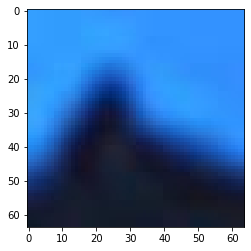

In [52]:
sample_path = "../input/patches/patches/cnntrain/10_132506.jpg_02.jpg"
# check sample image
img = cv2.imread(sample_path)
# change to gray
# img =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img )

In [53]:

# function to get the resolution size from  image path

def extract_resolution(img_path):
    resolution = img_path.split("_")[0]
    try:
        return int(resolution)
    except Exception as e:
        #print(img_path)
        #print(f"Exception occureed  {e}")
        return None

In [54]:
# test with a sample
extract_resolution("10_132506.jpg_02.jpg")

10

In [55]:
# read all image resultions
# function to get all resolutions
def get_img_resolution_and_images(img_dir):  
    res =[]
    data =[]
    for img_path in os.listdir(img_dir):
        resolution = extract_resolution(img_path)
        if resolution:
            #print(f"{img_dir}/{img_path}")
            img = cv2.imread(f"{img_dir}/{img_path}")                       
            # convert to grayscale
            #gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
            data.append(img)
            res.append(resolution)
        else:
            print("An error Occured")
    print("Finished extracting")
    
    return np.array(data) , np.array(res)

In [56]:
train_data ,train_resolutions = get_img_resolution_and_images(train_dir)
test_data ,test_resolutions = get_img_resolution_and_images(test_dir)

Finished extracting
An error Occured
Finished extracting


In [57]:
# check train size
train_data.shape , train_resolutions.shape

((18059, 64, 64, 3), (18059,))

In [58]:
# check test size
test_data.shape , test_resolutions.shape

((2261, 64, 64, 3), (2261,))

In [59]:
# # divide train data into training and validation set
# X_train , Xval , y_train , yval =train_test_split(train_data/255.0 ,
#                                                  train_resolutions ,
#                                                  test_size=0.15,
#                                                  random_state =2021)

In [60]:
from sklearn.utils import shuffle

train_data , train_resolutions = shuffle(train_data , train_resolutions , random_state = 42)
test_data , test_resolutions = shuffle(test_data , test_resolutions , random_state = 42)

In [61]:
# normalize the images so that pixel ranges from 0 to 1
Xtrain , Xtest = train_data/255.0 , test_data/255.0
Ytrain , Ytest = train_resolutions , test_resolutions

In [62]:
# check the shape of the images
Xtrain.shape , Ytrain.shape , Xtest.shape , Ytest.shape

((18059, 64, 64, 3), (18059,), (2261, 64, 64, 3), (2261,))

In [63]:
# create baseline model
def get_cnn_model():
    # build a sequential model
    from tensorflow.keras.layers import InputLayer
    model = Sequential()
    model.add(InputLayer(input_shape=(64, 64, 3)))

    # 1st conv block
    model.add(Conv2D(64, (5, 5), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    # 2nd conv block
    model.add(Conv2D(128, (5, 5), activation='relu', strides=(2, 2), padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 3rd conv block
    model.add(Conv2D(256, (3, 3), activation='relu', strides=(2, 2), padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
    model.add(BatchNormalization())
    # 4rd conv block
    model.add(Conv2D(160, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
    model.add(BatchNormalization())
    # 5rd conv block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    # ANN block
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(units=32, activation='relu'))
    # output layer
    model.add(Dense(units=1 , activation='softplus'))
    return model

In [64]:
q1_model = get_cnn_model()


# check model summary
q1_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 2, 256)        

- Train a CNN for 100 epochs with momentum 0.9 using the square loss (1). Use the SGD optimizer with an appropriate learning rate and $\lambda = 0.0001$ (weight decay).

- Start with minibatch size 32 and double it every 20 epochs and to obtain a good training $R^{2}$ (at least 0.9).

- Show a plot of the loss function vs epoch number for the training set and the test set.

- Show another plot of the training and test $R^{2}$ vs epoch number.

In [65]:
# define a function to compute r2 score
from keras import backend as K
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [66]:
len(Xtest)
# batch

2261

In [67]:
# the baseline model is going to be done with a small number of epochs
# compile 
LR = 1e-5
epochs = 100
batch =32

from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import SGD
optimizer = SGD(decay=0.0001,lr=LR , momentum=0.9)
# set early stopping
early_stop = EarlyStopping(monitor="val_R2",mode="max",patience=20,restore_best_weights=True)

print("***** Started Compiling model and optimization...................")
q1_model.compile(
    loss="mse", 
    optimizer=optimizer ,
    metrics=[R2]
)

# train 
print("Begin training ......")
q1_history= q1_model.fit(Xtrain, Ytrain, batch_size=batch,
                    steps_per_epoch=len(Xtrain)//batch,
                    validation_data=(Xtest, Ytest),
                    validation_steps=len(Xtest) // batch,
                    epochs=epochs,
                    callbacks =[early_stop]
                      )


***** Started Compiling model and optimization...................
Begin training ......
Epoch 1/100
564/564 [==============================] - 6s 10ms/step - loss: 575.2427 - R2: 0.0466 - val_loss: 275.7380 - val_R2: 0.6114
Epoch 2/100
564/564 [==============================] - 5s 9ms/step - loss: 174.5396 - R2: 0.7074 - val_loss: 869.1945 - val_R2: -0.2151
Epoch 3/100
564/564 [==============================] - 5s 10ms/step - loss: 121.7243 - R2: 0.7958 - val_loss: 496.4064 - val_R2: 0.3079
Epoch 4/100
564/564 [==============================] - 5s 9ms/step - loss: 102.0667 - R2: 0.8274 - val_loss: 727.7430 - val_R2: -0.0174
Epoch 5/100
564/564 [==============================] - 5s 9ms/step - loss: 89.3178 - R2: 0.8505 - val_loss: 104.8659 - val_R2: 0.8551
Epoch 6/100
564/564 [==============================] - 5s 9ms/step - loss: 78.0501 - R2: 0.8692 - val_loss: 196.7290 - val_R2: 0.7277
Epoch 7/100
564/564 [==============================] - 5s 9ms/step - loss: 71.4046 - R2: 0.8795 - va

In [68]:
preds =q1_model.predict(Xtest)

print(f"The model R2 score is  {np.round(r2_score(Ytest , preds) ,4)}")

The model R2 score is  0.9068


In [69]:
   
def create_review_plots(history , Question):    
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.title(f"\t\t***********{Question} Evaluation Plots *************")
    axes[0].plot(history.history['R2'] , label ="trainning r2" )
    axes[0].plot(history.history['val_R2'], label = "validation r2")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('r2_score')
    axes[0].legend(['r2_score Train','r2_score Test'])
    axes[0].grid(True)

    axes[1].plot(history.history['loss'] , label="trainning loss")
    axes[1].plot(history.history['val_loss'] , label="validation loss")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Error')
    axes[1].legend(['Error Train','Error Test'])
    axes[1].grid(True)
    axes[1].set_ylim([0 , None])
    axes[0].set_ylim([0 , None])
    axes[1].set_title(f"{Question} Model Loss Evaluation " , c ='red' , fontsize =15)
    axes[0].set_title(f"{Question} Model R2 Evaluation " , c ='red' , fontsize =15)

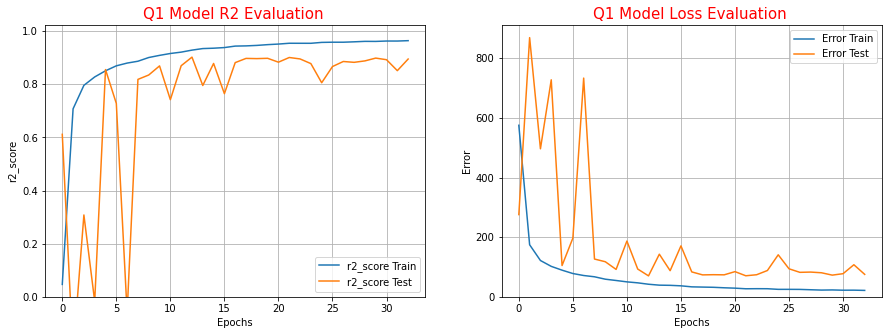

In [70]:
create_review_plots(q1_history , "Q1")

Now with a fixed minibatch of 512. You may not see a training $R^{2}$ of at least 0.9 in this case.

In [71]:
q2_model = get_cnn_model()

In [72]:
# the baseline model is going to be done with a small number of epochs
# compile 
LR = 5e-6
epochs = 100
batch =512

from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import SGD
optimizer = SGD(decay=0.0001,lr=LR , momentum=0.9)

print("***** Started Compiling model and optimization...................")
q2_model.compile(
    loss="mse", 
    optimizer=optimizer ,
    metrics=[R2]
)

# train 
print("Begin training ......")
q2_history = q2_model.fit(Xtrain, Ytrain, batch_size=batch,
                    validation_data=(Xtest, Ytest),
                    epochs=epochs)


***** Started Compiling model and optimization...................
Begin training ......
Epoch 1/100
36/36 [==============================] - 4s 87ms/step - loss: 3245.1729 - R2: -4.1300 - val_loss: 3254.4211 - val_R2: -3.3264
Epoch 2/100
36/36 [==============================] - 3s 79ms/step - loss: 1882.6202 - R2: -1.9505 - val_loss: 2743.8130 - val_R2: -2.6463
Epoch 3/100
36/36 [==============================] - 3s 77ms/step - loss: 405.6252 - R2: 0.3613 - val_loss: 1681.3706 - val_R2: -1.2334
Epoch 4/100
36/36 [==============================] - 3s 76ms/step - loss: 215.2199 - R2: 0.6600 - val_loss: 1408.7610 - val_R2: -0.8706
Epoch 5/100
36/36 [==============================] - 3s 76ms/step - loss: 184.7774 - R2: 0.7066 - val_loss: 1254.7499 - val_R2: -0.6661
Epoch 6/100
36/36 [==============================] - 3s 76ms/step - loss: 175.4587 - R2: 0.7210 - val_loss: 1064.0404 - val_R2: -0.4110
Epoch 7/100
36/36 [==============================] - 3s 77ms/step - loss: 142.9724 - R2: 0.7

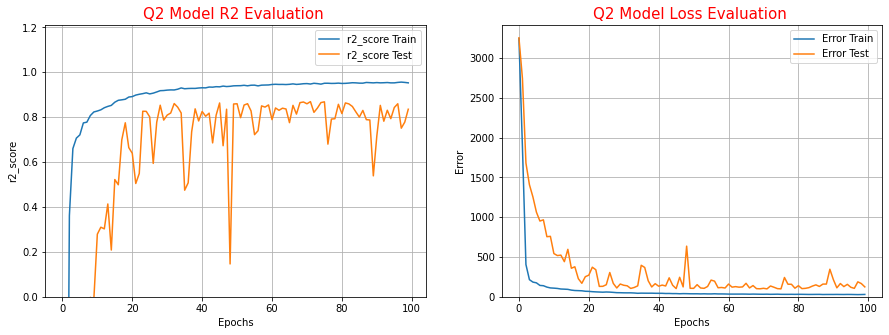

In [73]:
###### 
create_review_plots(q2_history , "Q2")

In [74]:
print(f"The model R2 score is  {np.round(r2_score(Ytest ,  q2_model.predict(Xtest)) ,4)}")

The model R2 score is  0.8351


In [75]:
# plotting residual plot
residuals_test = Ytest-np.array([x[0] for x in q1_model.predict(Xtest) ])
residuals_train = Ytrain-np.array([x[0] for x in q1_model.predict(Xtrain)])

Text(0.5, 1.0, 'Train Resdual Plot ')

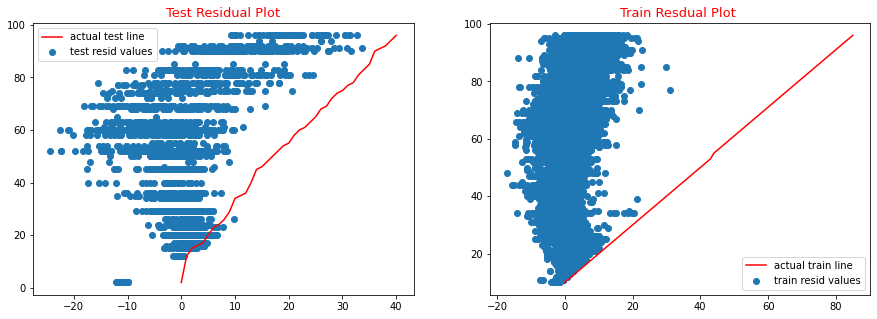

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
plt.title(f"\t\t***********Residual Evaluation Plots *************")
axes[0].scatter(residuals_test,Ytest , label = 'test resid values')
axes[0].plot(np.unique(sorted(Ytest)) , color ="r" , label='actual test line')
axes[0].legend()
axes[0].set_title(f"Test Residual Plot" , c ='red' , fontsize =13)

axes[1].scatter(residuals_train,Ytrain , label = 'train resid values')
axes[1].plot(np.unique(sorted(Ytrain)) , color ="r" , label='actual train line')
axes[1].legend()
axes[1].set_title(f"Train Resdual Plot " , c ='red' , fontsize =13)